In [1]:
import os
import argparse
import json
import random
import time
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision import transforms

In [2]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_val_dataset = datasets.CIFAR10('./data', train=True, transform=transform, download=True)
test_dataset = datasets.CIFAR10('./data', train=False, transform=transform, download=True)

train_size = int(len(train_val_dataset) * 0.8)
val_size = len(train_val_dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(train_val_dataset, [train_size, val_size])

dataset_partition = {'train' : train_dataset, 'val' : val_dataset, 'test' : test_dataset}

Files already downloaded and verified
Files already downloaded and verified


In [3]:
class MLP(nn.Module):
    def __init__(self, in_dim, out_dim, hidden_dim, n_layer, dropout_prob):
        super(MLP, self).__init__()

        # Model layer
        self.flattne = nn.Flatten()
        self.fc1 = nn.Linear(in_dim, hidden_dim)
        self.layer = nn.ModuleList()
        for l in range(n_layer):
            self.layer.append(nn.Linear(hidden_dim, hidden_dim))
        self.fc2 = nn.Linear(hidden_dim, out_dim)

        # Regularization
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, inputs):
        x = self.flattne(inputs)
        x = F.relu(self.fc1(x))
        for i in range(len(self.layer)):
            x = F.relu(self.layer[i](x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [4]:
class CNN(nn.Module):
    def __init__(self, out_dim):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, 3, 1, 1)
        self.conv2 = nn.Conv2d(32, 128, 3, 1, 1)

        self.act = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(2, 2)
        self.maxpool2 = nn.MaxPool2d(2, 2)

        self.fc = nn.Linear(128*8*8, out_dim)

    def forward(self, inputs):

        x = self.conv1(inputs) # (B, 32, 32, 32)
        x = self.act(x)
        x = self.maxpool1(x) # (B, 32, 16, 16)
        
        x = self.conv2(x) # (B, 128, 16, 16)
        x = self.act(x)
        x = self.maxpool2(x) # B, (128, 8, 8)
        x = x.view(x.size(0), -1) # (B, -1)
        output = self.fc(x) # (B, output_dim)
        return output

In [5]:
cfg = {'VGG11' : [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']}

class VGG(nn.Module):
    def __init__(self, model_code, use_bn):
        super(VGG, self).__init__()
        self.use_bn = use_bn

        self.cnn_layer = self._make_layers(model_code, 3, use_bn)

        self.classifier = nn.Sequential(nn.Linear(512, 32), nn.ReLU(), nn.Linear(32, 10))

    def forward(self, inputs):
        x = self.cnn_layer(inputs)
        x = x.view(x.size(0), -1)
        output = self.classifier(x)
        return output
    
    def _make_layers(self, model_code, in_channels, use_bn):
        layers = []
        for x in cfg[model_code]:
            if x == 'M':
                layers.append(nn.MaxPool2d(2, 2))
            else:
                layers.append(nn.Conv2d(in_channels, x, 3, 1, 1,))
                if self.use_bn:
                    layers.append(nn.BatchNorm2d(x))
                layers.append(nn.ReLU())
                in_channels = x
        return nn.Sequential(*layers)

In [6]:
def train_step(model, dataset_partition ,optimizer, loss_fn, device, args):
    train_dataloader = DataLoader(dataset_partition['train'], batch_size=args.batch_size, shuffle=True, drop_last=True)

    model = model.to(device)
    train_loss = 0.0
    train_acc = 0.0

    model.train()

    for img, label in train_dataloader:
        img, label = img.to(device), label.to(device)
        optimizer.zero_grad()

        pred = model(img)
        loss = loss_fn(pred, label)

        loss.backward()
        optimizer.step()

        train_loss += loss.cpu().detach().numpy()

        prediction = torch.argmax(pred, dim=-1)
        train_acc += torch.eq(prediction, label).sum().cpu().detach().numpy()

    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader.dataset)

    return model, train_loss, train_acc


def val_step(model, dataset_partition, loss_fn, device, args):
    val_dataloader = DataLoader(dataset_partition['val'], batch_size=args.batch_size, drop_last=True)

    model = model.to(device)
    val_loss = 0.0
    val_acc = 0.0

    model.eval()
    with torch.no_grad():
        for img, label in val_dataloader:
            img, label = img.to(device), label.to(device)

            pred = model(img)
            loss = loss_fn(pred, label)

            val_loss += loss.cpu().detach().numpy()


            prediction = torch.argmax(pred, dim=-1)
            val_acc += torch.eq(prediction, label).sum().cpu().detach().numpy()
        
        val_loss /= len(val_dataloader)
        val_acc /= len(val_dataloader.dataset)

    return model, val_loss, val_acc


def test_step(model, dataset_partition, device, args):
    test_dataloader = DataLoader(dataset_partition['test'], batch_size=args.batch_size, drop_last=True)

    model = model.to(device)
    test_acc = 0.0

    model.eval()
    with torch.no_grad():
        for img, label in test_dataloader:
            img, label = img.to(device), label.to(device)

            pred = model(img)
            prediction = torch.argmax(pred, dim=-1)
            test_acc += torch.eq(prediction, label).sum().cpu().detach().numpy()
        
        test_acc /= len(test_dataloader.dataset)

    return model, test_acc

In [7]:
def experiment(dataset_partition, args, device):

    if args.model_name == 'MLP':
        model = MLP(args.in_dim, args.out_dim, args.hidden_dim, args.n_layer, args.dropout_prob)
    elif args.model_name == 'VGG':
        model = VGG('VGG11', args.use_bn)
    elif args.model_name == 'CNN':
        model = CNN(args.out_dim)
    else:
        raise ValueError('Valid model should be chosen [MLP, VGG, CNN]')
    
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.CrossEntropyLoss()

    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for epoch in range(args.epochs):

        ts = time.time()
        model, train_loss, train_acc = train_step(model, dataset_partition, optimizer, loss_fn, device, args)
        model, val_loss, val_acc = val_step(model, dataset_partition, loss_fn, device, args)
        te = time.time()

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        print('Epoch = {}, ACCURACY(Train/Valid) : ({:.2f}/{:.2f}), LOSS(Train/Valid) : ({:.2f}/{:.2f}), TOOK Time (sec) : {:.2f}'.format(
            epoch + 1, train_acc*100, val_acc*100, train_loss, val_loss, te-ts
        ))

    model, test_acc = test_step(model, dataset_partition, device, args)
    print('Train step was finished , TEST ACCURACY : {:.2f}'.format(test_acc*100))

    results = {}
    results['train_losses'] = train_losses
    results['val_losses'] = val_losses
    results['train_accs'] = train_accs
    results['val_accs'] = val_accs
    results['test_acc'] = test_acc


    results['final_train_acc'] = train_acc
    results['final_train_loss'] = train_loss
    results['final_val_acc'] = val_acc
    results['final_val_loss'] = val_loss
    results['final_test_acc'] = test_acc


    return model, vars(args), results

In [8]:
def save_exp_results(setting, results):

    exp_name = setting['exp_name']
    dir_path = './results'
    if not os.path.exists(dir_path):
        os.mkdir(dir_path)
    file_name = f'{exp_name}_{datetime.now()}.json'
    file_path = os.path.join(dir_path, file_name)

    results.update(setting)
    with open(file_path, 'w') as f:
        json.dump(results, f)

def load_exp_results(exp_name):
    dir_path = './results'
    file_list = [f for f in os.listdir(dir_path) if exp_name in f]

    list_results = []
    for file in file_list:
        if '.json' in file:
            with open(os.path.join(dir_path, file), 'r') as f:
                list_results.append(json.load(f))
    return pd.DataFrame(list_results)


# Visulaiation

def plot_acc(results, var1=None, var2=None):
    fig, ax = plt.subplots(1, 3, figsize=(10, 3))

    sns.barplot(data=results, x=var1, y='final_train_acc', hue=var2, ax=ax[0])
    sns.barplot(data=results, x=var1, y='final_val_acc', hue=var2, ax=ax[1])
    sns.barplot(data=results, x=var1, y='final_test_acc', hue=var2, ax=ax[2])

    ax[0].set_title('Train Accuracy')
    ax[1].set_title('Val Accuracy')
    ax[2].set_title('Test Accuracy')

    plt.tight_layout()
    plt.show()

{'exp_name': 'model_name', 'in_dim': 3072, 'hidden_dim': 128, 'n_layer': 3, 'out_dim': 10, 'dropout_prob': 0.2, 'use_bn': True, 'epochs': 5, 'batch_size': 256, 'model_name': 'MLP'}
Epoch = 1, ACCURACY(Train/Valid) : (35.00/40.99), LOSS(Train/Valid) : (1.80/1.64), TOOK Time (sec) : 4.03
Epoch = 2, ACCURACY(Train/Valid) : (45.07/46.25), LOSS(Train/Valid) : (1.55/1.51), TOOK Time (sec) : 3.74
Epoch = 3, ACCURACY(Train/Valid) : (49.34/47.98), LOSS(Train/Valid) : (1.43/1.46), TOOK Time (sec) : 3.72
Epoch = 4, ACCURACY(Train/Valid) : (52.19/48.83), LOSS(Train/Valid) : (1.35/1.43), TOOK Time (sec) : 3.73
Epoch = 5, ACCURACY(Train/Valid) : (54.95/49.77), LOSS(Train/Valid) : (1.28/1.42), TOOK Time (sec) : 3.70
Train step was finished , TEST ACCURACY : 50.69
{'exp_name': 'model_name', 'in_dim': 3072, 'hidden_dim': 128, 'n_layer': 3, 'out_dim': 10, 'dropout_prob': 0.2, 'use_bn': True, 'epochs': 5, 'batch_size': 256, 'model_name': 'CNN'}
Epoch = 1, ACCURACY(Train/Valid) : (45.68/54.47), LOSS(Train

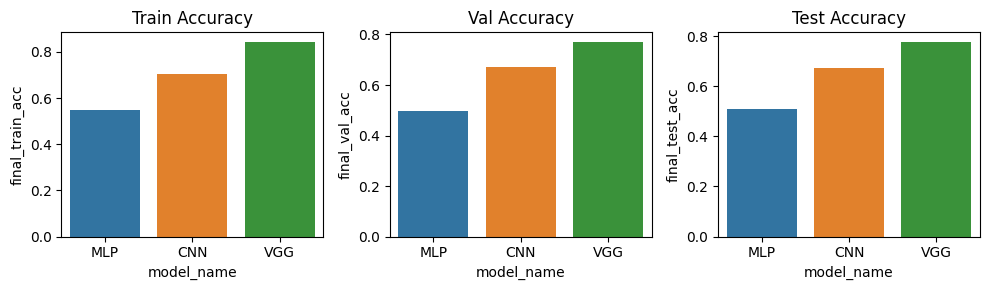

In [9]:
# Experiment

# Seed initialization
SEED = 123
np.random.seed(SEED)
torch.manual_seed(SEED)

# DEVICE
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    deveice = torch.device('cpu')

# Experiment_name
parser = argparse.ArgumentParser()
args = parser.parse_args("")

args.exp_name = 'model_name'

# Model capacity
args.in_dim = 3072  # MLP
args.hidden_dim = 128 # MLP
args.n_layer = 3 # MLP

args.out_dim = 10

# Regularizatioin
args.dropout_prob = 0.2 # MLP
args.use_bn = True 

# Training
args.epochs = 5
args.batch_size = 256

# Experiment values
exp_var = 'model_name'
list_exp_var = ['MLP', 'CNN', 'VGG']

for var in list_exp_var:
    setattr(args, exp_var, var)
    print(vars(args))
    model, setting, results = experiment(dataset_partition, args, device)

    save_exp_results(setting, results)
results = load_exp_results('model_name')

plot_acc(results, 'model_name')